# DefocusTrackerAI - Clustering

In this notebook, we will explore a framework to find clusters of particle trajectories. In particular, we will introduce the feature extraction from the raw trajectory data, the deep-sparse autoencoder for dimensionality reduction and feature learning, and ultimately the HDBSCAN clustering algorithm including the clustering validation metrics. In this walk-through example, we use a synthetic dataset that includes linear, sinusoidal, random-walk and elliptic trajectories. This was used for the validation of the present framewok.

## Outline:

- [1. Prepare notebook (package installation)](#1)
- [2. Shallow features extraction](#3)
- [3. Deep-sparse autoencoder](#4)
- [4. HDBSCAN clustering](#5)

_**Note:** For further details, please refer to the following publications: ..._

<a name="1"></a>

## 1. Notebook Preparation

First, let's run the following cells to setup the Google Drive (if needed), the working directory and install the requirements for the DefocusTrackerAI trajectory clustering module.


In [18]:
!git clone https://oauth2:gitlab.com/goncalo.coutinho/eda-2dparticletracjectory.git

Cloning into 'defocustrackerAI-clustering'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 59 (delta 14), reused 0 (delta 0), pack-reused 23 (from 1)
Receiving objects: 100% (59/59), 2.61 MiB | 5.20 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [19]:
cd /content/clustering

/content/clustering


In [ ]:
pip install .

<a name="3"></a>

## 2.  Shallow features extration

Now, let's use the Python class `FeaturesExtractor` to obtain the shallow features from our trajectory data. This is a fundamental step since the trajectories have a different lenghts and here we transformed them into a fixed-length representation with N features, i.e., it creates a data set with M rows (number of trajectories) and N columns (number of features).

For our case, we want trajectories that start outside the cell-free layer (CFL). This selection task can be performed with the `search_boundaries` parameter, a `list` containing the boundaries for the y- and z-coordinates, as well as a minimum trajectory length (default 1). To exclude one can just remove it from the parameters or for instance define as `[0, 1, 0, 1, 10]` to use minimum track length option (here set as `10`).

The `ShallowFeaturesExtractor` class itself converts each trajectory in multiple segments based on sequences of continuous lateral movement (`DY > 0` or `DY < 0`) and then computes a set of descriptive statistics on each quantity `[x, y, z, dx, dy, dxx, dyy, dydx, turning_angles, curvature]` using the Pandas method `.describe()`. We also considered the `tortuosity`.

_**NOTE:** The class `ShallowFeaturesExtractor` was designed specifically for our research topic. For other particle trajectory data, we encourage the user to adapt our version or develop a new extractor class._

In [21]:
""" Extract features from the trajectory data """
from clustering.utils.FeaturesExtractor import FeaturesExtractor
file_path = './data-test/'
filename = 'dataset_synthetic.csv'
FeaturesExtractor(file_path,
                  filename)

💾 Working directory: /content/clustering
🕐 Computing features, this may take a while... 
✔️ Features are now ready! 
➔ Number of trajectories in the dataset: 3000
➔ Number of features: 50


<a name="4"></a>
## 4 - Deep-sparse autoencoder

Now let's build the `deep-sparse autoencoder (DAS)` using the class `DeepAutoencoder`. The `DAS` are type of `neural network` that compresses and reconstructs the input data using an `encoder` and a `decoder` without supervision. For our work, we will use the trained`encoder` to compress our features and thus obtain a more meaningful representation of our data in lower dimensional space (i.e., a `latent representation`). In the most general form, the architecture consists of an `input layer` with `n` neurons, an encoder with `k<n` (in `k-dimensional latent space`), and a decoder with `n` neurons.

Our implementation uses the `Kullback-Leibler divergence` as activity regularizer and includes `EarlyStopping` to prevent overfitting.

To create the `DAS`, we need to define the following parameters:

* Number of encoding dimensions i.e., number of neurons per encoding layer
* Learning rate
* Batch size
* Sparsity target
* Sparsity weight
* Activation function for hidden layers (default is ReLU)
* Activation function of the output layer (default is linear)
* Loss function (default is mean-squared error - mse)
* Number of epochs

_**NOTE:** For further details on the current implementation the user should refer to the following publication:...._

In [22]:
""" Build deep-sparse autoencoder, train and get latent space. """
from clustering.utils.DeepAutoencoder import DeepAutoencoder
file_path = './runs/features/dataset_synthetic_1/'
filename = 'features.csv'
ae_ = DeepAutoencoder(file_path,
                      filename)

💾 Working directory: /content/clustering
⏳ Building autoencoder...
⏳ Training autoencoder...
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.4704 - mse: 0.1001
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9240 - mse: 0.0062
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8606 - mse: 0.0045
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8579 - mse: 0.0042
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8545 - mse: 0.0040
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7929 - mse: 0.0040
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7913 - mse: 0.0038
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7904 - mse: 0.0037
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7897 - mse: 0.0037
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7892 - mse: 0.0036
⏳ Getting latent representation...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✔️ Latent representation is now ready and 

<a name="5"></a>
## 5 - HDBSCAN clustering

Now we can finally feed our encoded features (`ae_features`) to the clustering algorithm. For the clustering of particle trajectories, it is the author's opinion that the `HDBSCAN` is best-suited algorithm, however the user could try other options such as the `K-means` or `DBSCAN`.

The `HDBSCAN` clustering algorithm has only one hyper-parameter `N`, corresponding to the minimum number of samples to constitute a cluster. To fine tune `N`, we created the class `UnsupervisedClustering` that has the methods `hdbscan_tune`, `hdbscan_` to fine tune and obtain a solution for single `N`, respectively. These methods already include the computation of `clustering validation metrics` such as the `silhouette score (SS)`, `Davies-Bouldin index (DBI)` and the `Calinski-Harabasz index (CHI)` which are used to find the optimal clustering solution.

In the fine tunning step, we use the class `UnsupervisedClustering` with the `hdbscan_tune` method. It takes a range o values for `N` (minimum cluster size) as a `numpy` array, the display allows to see the `clustering validation metrics` throughout the process (default values is `True`). The `clustering validation metrics (cvms)` are store as `pandas dataframe` in the attribute `metrics_tune`. In addition, to find the optimal solution the `cvms` are merged in a normalized-combined score. The optimal solution will therefore correspond to the maximum of the `ensemble_score` included in `metrics_tune`.

_**NOTE:** Further details on the choice of the clustering algorithm are given in the following publication:..._

💾 Working directory: /content/clustering
⏳ Clustering data for N from 5 to 79, this may take a while...
✔️ Clustering solutions are now ready, check the plot!
🏆 Best clustering solution:
{'N': 58, 'Cluster counts': [48, 278, 751, 729, 412, 782], 'SS': 0.747, 'DBI': 1.317, 'CHI': 6891.751}

💾 Clustering labels of the best solution save as .csv file at /content/clustering/runs/clustering/dataset_synthetic_1_1_1.


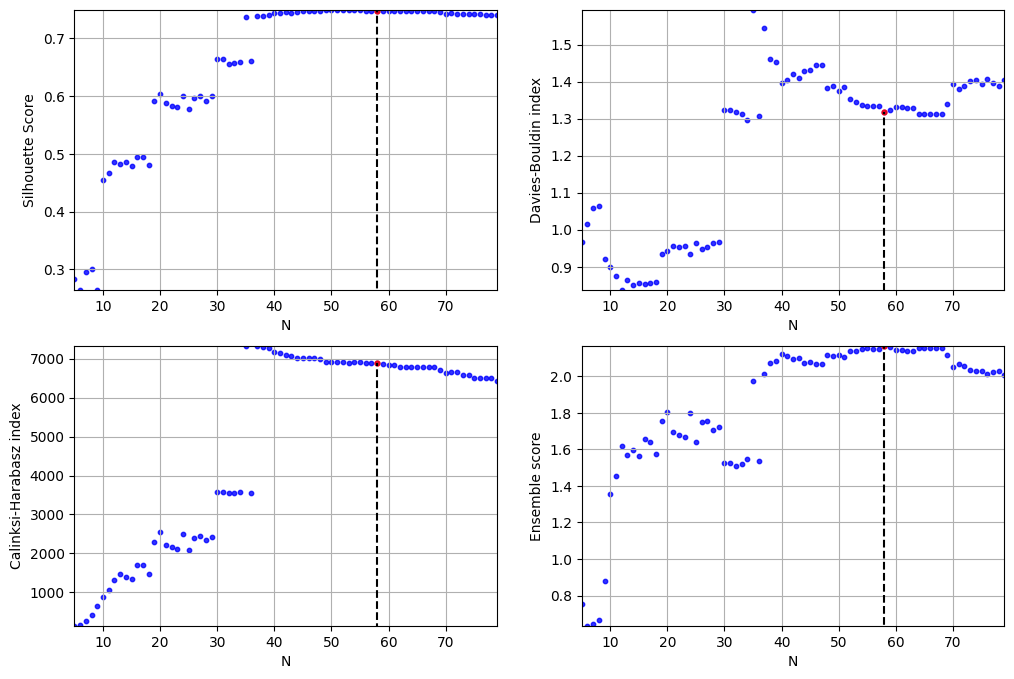

In [23]:
import numpy as np
from clustering.utils.UnsupervisedClustering import  UnsupervisedClustering
file_path = './runs/autoencoder/dataset_synthetic_1_1/'
filename = 'ae_features.csv'
clusterer = UnsupervisedClustering(file_path,
                                   filename)
clusterer.hdbscan_tune(N_range = np.arange(5,80), display = False)

In [24]:
""" This precision-recall report is aimed for the provided synthetic dataset,
for other cases, the true labels must be modified. Please note that the order of
the labels may be different from the true labels and HDBSCAN labels and should be
accordingly adjusted."""
clusterer.precision_recall()

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       750
         2.0       1.00      0.97      0.99       750
         3.0       1.00      0.55      0.71       750
         4.0       0.95      0.99      0.97       750

   micro avg       0.98      0.88      0.93      3000
   macro avg       0.99      0.88      0.92      3000
weighted avg       0.99      0.88      0.92      3000

